In [ ]:
!pip install langdetect
!pip install deep_translator
!pip install nltk
!pip install tensorflow

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Some important links for this notebook:
#### The original dataset is here: [Dataset](https://drive.google.com/file/d/1UCA3GOkJxn4JaoQx8k0VY8E-dpV94xLP/view?usp=sharing)
#### Some EDAs and a sample Classification is done here: [EDA](https://colab.research.google.com/drive/14Ee2MtvksiqDZ8BrJG8NStJAwQHl0FAQ?usp=sharing)
#### The pre-processing part is included here: [Pre-Processing](https://colab.research.google.com/drive/17RNeBI9gj2uMdhyHNLCMXz_e4ymE89-0?usp=sharing)
#### The pre-processed data can be found here: [Processed Data 1](https://drive.google.com/file/d/1IIkpYWLqDXREFjBDl69exeTTA4ZigCms/view?usp=sharing) & [Processed Data 2](https://drive.google.com/file/d/1-0USoUd3cP-f0pDGdWXY_WO8cgYkYc-o/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/Internship/Model\ I

Mounted at /content/drive
/content/drive/My Drive/Internship/Model I


In [ ]:
df = pd.read_csv('processed_data1.csv')

In [ ]:
df.columns

Index(['title', 'processed_title', 'custom_audience_persona'], dtype='object')

In [ ]:
print(df['custom_audience_persona'].unique())


['Data Engineer' 'Unprioritized' 'Data Scientist' 'Data Analyst'
 'Data Architect' 'Business Execs' 'CIO' 'CDO']


In [ ]:
# Displaying the first few rows and basic information about the dataset
print(df.head())
print(df.info())

                                               title  \
0                   VP Digital Transformation DevOps   
1                             Senior Patent Attorney   
2         Assistant Professor, School of Engineering   
3  Engineering Director, Software Products, Elect...   
4                 MS Data Science Graduating Student   

                                    processed_title custom_audience_persona  
0                  vp digital transformation devops           Data Engineer  
1                            senior patent attorney           Unprioritized  
2            assistant professor school engineering           Data Engineer  
3  engineering director software product electrolux           Data Engineer  
4                 m data science graduating student          Data Scientist  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034452 entries, 0 to 2034451
Data columns (total 3 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   titl

In [ ]:
# Separating into features and labels
X = df['processed_title']
y = df['custom_audience_persona']

# Encoding the labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Creating a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=50)

# Replacing NaN values in X with empty strings
X = X.fillna('')

# Fittin and transforming the text data
X_tfidf = vectorizer.fit_transform(X)

# # Applying SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_tfidf, y_encoded)

# X_resampled = pd.Series(X_resampled.toarray().flatten())

# # Splitting the resampled data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
# )

In [ ]:
# Splitting the labeled data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_encoded, test_size=0.2, stratify=y, random_state=42)

print("\nTraining set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])


Training set size: 1627561
Validation set size: 406891


In [ ]:
# Calculating class proportions in the original dataset
original_proportions = df['custom_audience_persona'].value_counts(normalize=True)
print("\nOriginal class proportions:\n", original_proportions)

# Calculating class proportions in the training set
train_proportions = pd.Series(y_train).value_counts(normalize=True)
print("\nTraining set class proportions:\n", train_proportions)

# Calculating class proportions in the validation set
val_proportions = pd.Series(y_val).value_counts(normalize=True)
print("\nValidation set class proportions:\n", val_proportions)



Original class proportions:
 custom_audience_persona
Unprioritized     0.497771
Data Engineer     0.189880
Data Analyst      0.126932
Data Scientist    0.075815
Business Execs    0.045162
Data Architect    0.039981
CIO               0.019976
CDO               0.004484
Name: proportion, dtype: float64

Training set class proportions:
 7    0.497771
5    0.189880
3    0.126932
6    0.075815
0    0.045161
4    0.039981
2    0.019976
1    0.004484
Name: proportion, dtype: float64

Validation set class proportions:
 7    0.497772
5    0.189879
3    0.126933
6    0.075814
0    0.045162
4    0.039981
2    0.019976
1    0.004483
Name: proportion, dtype: float64


In [ ]:
 # Tokenizing and pad the sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_length = 100

# Get the original text data from 'processed_title' column in df
X_text = df['processed_title'].astype(str)  # Convert to string type

# Splitting the text data into training and validation sets
X_train_text, X_val_text, _, _ = train_test_split(
    X_text, y_encoded, test_size=0.2, stratify=y, random_state=42
)

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)

# Tokenize the text data
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)

print("\nShape of padded training data:", X_train_pad.shape)
print("Shape of padded validation data:", X_val_pad.shape)


Shape of padded training data: (1627561, 100)
Shape of padded validation data: (406891, 100)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_pad, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [ ]:
# Creating DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# Defining the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

In [ ]:
# Initializing the model
vocab_size = max_words
embedding_dim = 128
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)

In [ ]:
# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        texts, labels = batch
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')

print("Training completed.")

Epoch 1/1, Validation Accuracy: 0.9751
Training completed.


In [ ]:
# Evaluating on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        texts, labels = batch
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9751


In [ ]:
# Example titles:
titles_to_test = [
    "CIO",
    "Scientist",
    "Student"
]

test_sequences = tokenizer.texts_to_sequences(titles_to_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

test_tensor = torch.tensor(test_padded, dtype=torch.long)


model.eval()
with torch.no_grad():
  outputs = model(test_tensor)
  _, predicted_labels = torch.max(outputs.data, 1)

predicted_categories = label_encoder.inverse_transform(predicted_labels.numpy())

for title, category in zip(titles_to_test, predicted_categories):
  print(f"Title: {title}, Predicted Category: {category}")


Title: CIO, Predicted Category: CIO
Title: Scientist, Predicted Category: Data Scientist
Title: Student, Predicted Category: Unprioritized


In [ ]:
import torch
import pickle

# Save the model
torch.save(model.state_dict(), 'model_for_model1.pth')

# Save the tokenizer
with open('tokenizer_for_model1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder_for_model1.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


Loading the model, encoder and tokenizer and testing it on sample titles.

In [ ]:
import torch
import torch.nn as nn
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model (Run for the variable values below)
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model_for_model1.pth'))
model.eval()

# Load the tokenizer
with open('tokenizer_for_model1.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the label encoder
with open('label_encoder_for_model1.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Example descriptions to test
descriptions_to_test = [
    "Chief Data Officer",
    "Data Scientist",
    "Marketing Manager"
]

# Preprocess the descriptions
test_sequences = tokenizer.texts_to_sequences(descriptions_to_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length)
test_tensor = torch.tensor(test_padded, dtype=torch.long)

# Make predictions
with torch.no_grad():
    outputs = model(test_tensor)
    _, predicted_labels = torch.max(outputs.data, 1)

predicted_categories = label_encoder.inverse_transform(predicted_labels.numpy())

# Print the results
for description, category in zip(descriptions_to_test, predicted_categories):
    print(f"Description: {description}, Predicted Category: {category}")


<ipython-input-19-98969b15e7fa>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_for_model1.pth'))


Description: Chief Data Officer, Predicted Category: CDO
Description: Data Scientist, Predicted Category: Data Scientist
Description: Marketing Manager, Predicted Category: Unprioritized


In [ ]:
from sklearn.metrics import classification_report

# Example using the validation loader and model:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        texts, labels = batch
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, output_dict=True)
print(classification_report(all_labels, all_preds))

# Total Recall
total_recall = report['macro avg']['recall']
print(f"\nTotal Recall: {total_recall}")

# Find class with least recall
min_recall = 1.0
min_recall_class = None

for class_label, metrics in report.items():
    if isinstance(metrics, dict) and 'recall' in metrics:
      if metrics['recall'] < min_recall :
        min_recall = metrics['recall']
        min_recall_class = class_label

if min_recall_class:
  print(f"\nClass with least recall: {min_recall_class} ({min_recall:.2f})")

  # Analyze potential causes (example)
  print("\nPotential causes for low recall:")
  print("- Class imbalance: Check if the minority class has significantly fewer samples.")
  print("- Feature insufficiency: The features may not adequately capture information specific to the minority class.")
  print("- Model complexity: The model may be too simple to learn the complex patterns in the minority class.")
  print("- Data quality: Investigate the data quality in the minority class for any inconsistencies or errors.")
else:
    print("\nCould not determine class with minimum recall.")


              precision    recall  f1-score   support

           0       0.95      0.96      0.95     18376
           1       0.95      0.91      0.93      1824
           2       0.97      0.77      0.86      8128
           3       0.99      0.98      0.98     51648
           4       0.99      0.94      0.97     16268
           5       0.97      0.96      0.96     77260
           6       0.99      0.96      0.98     30848
           7       0.97      0.99      0.98    202539

    accuracy                           0.98    406891
   macro avg       0.97      0.94      0.95    406891
weighted avg       0.98      0.98      0.97    406891


Total Recall: 0.9365044761041583

Class with least recall: 2 (0.77)

Potential causes for low recall:
- Class imbalance: Check if the minority class has significantly fewer samples.
- Feature insufficiency: The features may not adequately capture information specific to the minority class.
- Model complexity: The model may be too simple to learn 


Class Name with lowest recall: CIO (0.77)

Further Analysis for low recall:
1. Confusion Matrix:
[[ 17702      9     51     14      1    196      9    394]
 [    33   1664     11     13      6     45     16     36]
 [   669     18   6293     51     89    319     28    661]
 [    14     16      2  50478      6    377     29    726]
 [     8      3      7     58  15345    309     31    507]
 [    70     18     40     91      5  74525     43   2468]
 [    19      6     10    119     15    354  29754    571]
 [   202     21     53     73      5   1093     82 201010]]


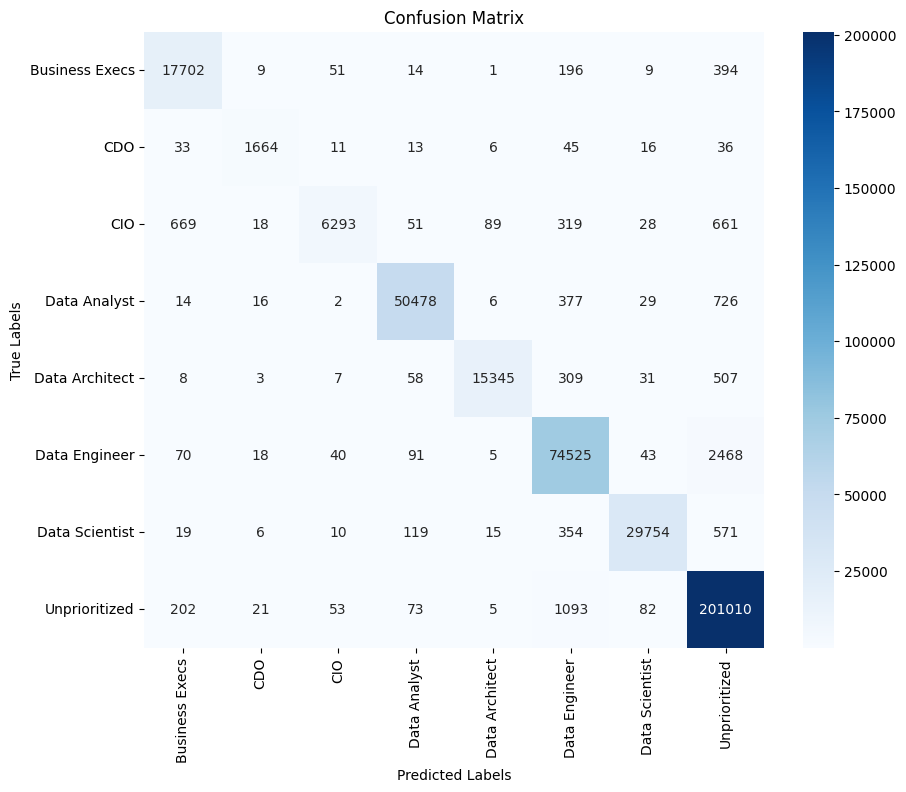

2. Examples of misclassified instances:
Example 1:
Original Title: technical support engineer
True Label: CIO
Predicted Label: Data Analyst
--------------------
Example 2:
Original Title: director strategy data science
True Label: CIO
Predicted Label: Business Execs
--------------------
Example 3:
Original Title: head user experience
True Label: CIO
Predicted Label: Data Analyst
--------------------
Example 4:
Original Title: supervisor operation warehouse
True Label: CIO
Predicted Label: Data Engineer
--------------------
Example 5:
Original Title: senior analyst
True Label: CIO
Predicted Label: Unprioritized
--------------------
3. Data distribution analysis for the class with lowest recall
4. Model's performance across other metrics:
Precision for CIO: 0.97
F1-score for CIO: 0.86
Support for CIO: 8128.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure min_recall_class is an integer
min_recall_class = int(min_recall_class)

# Get the class name corresponding to the minimum recall class index.
min_recall_class_name = label_encoder.inverse_transform([min_recall_class])[0]
print(f"\nClass Name with lowest recall: {min_recall_class_name} ({min_recall:.2f})")

#Further analysis
print("\nFurther Analysis for low recall:")
print("1. Confusion Matrix:")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)
# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("2. Examples of misclassified instances:")

# Find indices of misclassified instances for the class with the lowest recall.
misclassified_indices = np.where((np.array(all_labels) == min_recall_class) & (np.array(all_preds) != min_recall_class))[0]

# Display some misclassified instances along with their true and predicted labels.
num_examples = min(5, len(misclassified_indices)) # Limit to 5 examples or fewer.
for i in range(num_examples):
  index = misclassified_indices[i]
  original_title = df['processed_title'][index]
  true_label = label_encoder.inverse_transform([all_labels[index]])[0]
  predicted_label = label_encoder.inverse_transform([all_preds[index]])[0]
  print(f"Example {i+1}:")
  print(f"Original Title: {original_title}")
  print(f"True Label: {true_label}")
  print(f"Predicted Label: {predicted_label}")
  print("-" * 20)

print("3. Data distribution analysis for the class with lowest recall")
# Analyze the distribution of features for the class with the lowest recall.
# ... (add code for analyzing specific features)

print("4. Model's performance across other metrics:")
# Look at precision, F1-score, and support for the low-recall class.
print(f"Precision for {min_recall_class_name}: {report[str(min_recall_class)]['precision']:.2f}")
print(f"F1-score for {min_recall_class_name}: {report[str(min_recall_class)]['f1-score']:.2f}")
print(f"Support for {min_recall_class_name}: {report[str(min_recall_class)]['support']}")




In [ ]:
print("3. Data distribution analysis for the class with lowest recall")

# Number of data points for the class with lowest recall / total data points
cio_datapoints = df[df['custom_audience_persona'] == min_recall_class_name].shape[0]
total_datapoints = df.shape[0]
cio_ratio = cio_datapoints / total_datapoints
print(f"Ratio of CIO datapoints to total datapoints: {cio_ratio:.4f}")

3. Data distribution analysis for the class with lowest recall
Ratio of CIO datapoints to total datapoints: 0.0200


### The above apporach doesn't comply with the needs of the chief-level dataset simply because the dataset is too skewed so instead what we can also do is before model training involve a SMOTE sampling.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

%cd /content/drive/My\ Drive/Internship/Model\ II

# Loading the preprocessed dataset
df = pd.read_csv('processed_data2.csv')


/content/drive/My Drive/Internship/Model II


In [ ]:
# Undersampling the majority class 'Others'
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.custom_cdo_cio_cto == 'Others']
df_minority = df[df.custom_cdo_cio_cto != 'Others']

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,  # sample without replacement
                                 n_samples=10*len(df_minority),  # match minority class size
                                 random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
# Display new class counts
print(df_downsampled.custom_cdo_cio_cto.value_counts())

custom_cdo_cio_cto
Others    45190
CTO        2018
CIO        1749
CDO         560
CDAO        125
CAO          67
Name: count, dtype: int64


In [ ]:
df = df_downsampled

In [ ]:
# Splitting features and target
X = df['processed_title']
y = df['custom_cdo_cio_cto']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Tokenizing and padding sequences
max_words = 5000
max_length = 100

tokenizer = Tokenizer(num_words=max_words)

# Converting X_train to strings before fitting the tokenizer
X_train = X_train.astype(str)

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)

# Converting X_test to strings, handling potential NaN or float values
X_test = X_test.astype(str)

X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:
# # Applying SMOTE to balance the dataset
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pad, y_train)

In [ ]:
# Building the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(max_words, 32, input_length=max_length),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Training the model
batch_size = 32
epochs = 10

# Converting y_train_balanced to numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Convert X_train to a NumPy array with dtype=int32
X_train_array = np.array(X_train_pad, dtype=np.int32)  # X_train_pad is likely already a NumPy array, but ensuring dtype

history = model.fit(
    X_train_array, y_train_encoded,  # Use X_train_array here
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 105s 87ms/step - accuracy: 0.9072 - loss: 0.5128 - val_accuracy: 0.9497 - val_loss: 0.1650
Epoch 2/10
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 143s 88ms/step - accuracy: 0.9540 - loss: 0.1481 - val_accuracy: 0.9706 - val_loss: 0.1093
Epoch 3/10


KeyboardInterrupt: 

## The training was taking a lot of time so I stopped the process early and tried to see what weights and biases I got. This will require tweakes in hyperparameter which I will experiment soon.

In [ ]:
# Evaluating on test set
# Converting y_test to numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")

311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9711 - loss: 0.1088
Test accuracy: 0.9724


In [ ]:
# Example titles:
titles_to_test = [
    "Software Engineer",
    "Data Scientist",
    "CTO",
    "CISO",
    "Chief Data Officer",
    "Example title",
    "Another example title"
]

# Tokenizing and padding the test titles using the same tokenizer used for training
test_sequences = tokenizer.texts_to_sequences(titles_to_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

# Making predictions using model.predict()
predicted_labels = model.predict(test_padded)

# Getting the predicted class indices
predicted_labels = np.argmax(predicted_labels, axis=1)

# Converting predicted labels back to original categories
predicted_categories = label_encoder.inverse_transform(predicted_labels)

# Printing the predictions
for title, category in zip(titles_to_test, predicted_categories):
  print(f"Title: {title}, Predicted Category: {category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
Title: Software Engineer, Predicted Category: Others
Title: Data Scientist, Predicted Category: Others
Title: CTO, Predicted Category: CTO
Title: CISO, Predicted Category: CIO
Title: Chief Data Officer, Predicted Category: CDO
Title: Example title, Predicted Category: Others
Title: Another example title, Predicted Category: Others


In [ ]:
import pickle

# Save the model
model.save('model_for_model2.h5')

# Save the tokenizer
with open('tokenizer_for_model2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder_for_model2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('model_for_model2.h5')

# Load the tokenizer
with open('tokenizer_for_model2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the label encoder
with open('label_encoder_for_model2.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Example titles
titles_to_test = [
    "Software Engineer",
    "Data Scientist",
    "CTO",
    "CISO",
    "Chief Data Officer",
    "Example title",
    "Another example title"
]

# Tokenize and pad the test titles
max_length = 50
test_sequences = tokenizer.texts_to_sequences(titles_to_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

# Make predictions
predicted_labels = model.predict(test_padded)
predicted_labels = np.argmax(predicted_labels, axis=1)
predicted_categories = label_encoder.inverse_transform(predicted_labels)

# Print the results
for title, category in zip(titles_to_test, predicted_categories):
    print(f"Title: {title}, Predicted Category: {category}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Title: Software Engineer, Predicted Category: Others
Title: Data Scientist, Predicted Category: Others
Title: CTO, Predicted Category: CTO
Title: CISO, Predicted Category: CIO
Title: Chief Data Officer, Predicted Category: CDO
Title: Example title, Predicted Category: Others
Title: Another example title, Predicted Category: Others


In [ ]:
# Load the saved model
model = load_model('model_for_model2.h5')

# Load the tokenizer
with open('tokenizer_for_model2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the label encoder
with open('label_encoder_for_model2.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

In [ ]:
# Get the vocabulary size from the model's embedding layer
vocab_size = model.layers[0].input_dim # Get vocab_size from model

# Update the tokenizer's num_words to match the model's vocabulary size
tokenizer.num_words = vocab_size  # Ensures tokenizer and model are consistent


# Make predictions on the test set
# Assuming X_test is your original test data before padding
max_length = 100

# Tokenize and pad the test titles
X_test_sequences = tokenizer.texts_to_sequences(X_test) # X_test is the original test data before padding
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_length) # Pad sequences using the loaded tokenizer

predicted_labels = model.predict(X_test_pad)
predicted_labels = np.argmax(predicted_labels, axis=1)
predicted_categories = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({'processed_title': X_test, 'predicted_category': predicted_categories})

# Save predictions to a CSV file
predictions_df.to_csv('predictions2.csv', index=False)

311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [ ]:
import numpy as np
import torch
from sklearn.model_selection import KFold

# Define the number of folds for k-fold cross-validation
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results for each fold
accuracy_scores = []

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold+1}/{n_splits}")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # 1. Tokenize and pad the data for the current fold
    X_train_fold_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_fold_seq = tokenizer.texts_to_sequences(X_val_fold)
    X_train_fold_pad = pad_sequences(X_train_fold_seq, maxlen=max_length)
    X_val_fold_pad = pad_sequences(X_val_fold_seq, maxlen=max_length)

    # 2. Convert the padded sequences to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold_pad, dtype=torch.long)
    # Convert y_train_fold to numerical labels before creating a tensor
    y_train_fold_encoded = label_encoder.fit_transform(y_train_fold)  # Encode labels numerically
    y_train_tensor = torch.tensor(y_train_fold_encoded, dtype=torch.long)  # Create tensor with numerical labels
    X_val_tensor = torch.tensor(X_val_fold_pad, dtype=torch.long)
    # Convert y_val_fold to numerical labels before creating a tensor
    y_val_fold_encoded = label_encoder.fit_transform(y_val_fold)  # Encode labels numerically
    y_val_tensor = torch.tensor(y_val_fold_encoded, dtype=torch.long)  # Create tensor with numerical labels

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize a new model for each fold
    # Define embedding_dim, hidden_dim, and output_dim here
    embedding_dim = 128  # Example value
    hidden_dim = 128    # Example value
    output_dim = len(label_encoder.classes_) # Example assuming label_encoder is defined

    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())


    # Training the model using PyTorch training loop
    num_epochs = 5  # Number of training epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Reset gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Calculate loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update model parameters

        # Evaluate on validation set after each epoch
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}")



    # Evaluate the model on the validation set for the current fold
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracy_scores.append(accuracy)
    print(f"Fold {fold + 1} accuracy: {accuracy}")


# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print(f"\nAverage accuracy across {n_splits} folds: {average_accuracy}")

Fold 1/5
Epoch 1/5, Validation Accuracy: 0.9775
Epoch 2/5, Validation Accuracy: 0.9805


KeyboardInterrupt: 

Now what I've done below is:
- Predict all the rows classified as Others (as they were previously **null**)
- For the confidence scores above 0.9, classify as it is.
- For the confidence scores between 0.6 and 0.9, leave as **null** for manual review.
- For the confidence scores below 0.6, classify as Others.

It's in documentation and can be run in HPC servers.

In [ ]:
# import pandas as pd
# import numpy as np
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import pickle

# # Load the saved model, tokenizer, and label encoder
# model = load_model('model_for_model2.h5')
# with open('tokenizer_for_model2.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
# with open('label_encoder_for_model2.pickle', 'rb') as handle:
#     label_encoder = pickle.load(handle)

# # Load the data
# df = pd.read_csv('processed_data2.csv')

# # Prepare the data for prediction
# max_length = 50
# X = df['processed_title'].astype(str)
# sequences = tokenizer.texts_to_sequences(X)
# padded_sequences = pad_sequences(sequences, maxlen=max_length)

# # Make predictions
# predictions = model.predict(padded_sequences)
# predicted_labels = np.argmax(predictions, axis=1)
# predicted_categories = label_encoder.inverse_transform(predicted_labels)
# confidence_scores = np.max(predictions, axis=1)

# # Create a new column for predicted categories
# df['predicted_category'] = predicted_categories
# df['confidence_score'] = confidence_scores

# # Apply threshold logic
# others_indices = df[df['custom_cdo_cio_cto'] == 'Others'].index
# for i in others_indices:
#     if df.loc[i, 'confidence_score'] > 0.9:
#       # Classify as the majority confidence score
#         df.loc[i, 'custom_cdo_cio_cto'] = df.loc[i, 'predicted_category']
#     elif 0.6 <= df.loc[i, 'confidence_score'] < 0.9:
#       # Remove classification and mark as missing
#         df.loc[i, 'custom_cdo_cio_cto'] = np.nan
#     else:
#         # Classify as Others
#         df.loc[i, 'custom_cdo_cio_cto'] = 'Others'

# # Create subset DataFrame for predictions
# predictions_df = df.loc[others_indices, ['processed_title', 'predicted_category', 'confidence_score', 'custom_cdo_cio_cto']].copy()

# # Save the subset DataFrame
# predictions_df.to_csv('Predictions_for_model2.csv', index=False)

# # Save the updated DataFrame
# df.to_csv('predicted_dataset_for_model2.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved model, tokenizer, and label encoder
model = load_model('model_for_model2.h5')
with open('tokenizer_for_model2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('label_encoder_for_model2.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Sample description
sample_description = "Chief Data Officer"

# Preprocess the sample description
max_length = 50  # Ensure this matches the max_length used during training
test_sequences = tokenizer.texts_to_sequences([sample_description])
test_padded = pad_sequences(test_sequences, maxlen=max_length)

# Make prediction
prediction = model.predict(test_padded)
predicted_label = np.argmax(prediction, axis=1)[0]
predicted_category = label_encoder.inverse_transform([predicted_label])[0]
confidence_score = np.max(prediction, axis=1)[0]

# Apply confidence threshold
upper_threshold = 0.9
lower_threshold = 0.6

if confidence_score > upper_threshold:
  print(f"Description: {sample_description}, Predicted Category: {predicted_category}, Confidence: {confidence_score}")
elif confidence_score < lower_threshold:
  print(f"Description: {sample_description}, Predicted Category: Others, Confidence: {confidence_score}")
else:
  print(f"Description: {sample_description}, Prediction uncertain (confidence: {confidence_score}).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Description: Chief Data Officer, Predicted Category: CDO, Confidence: 0.9990630745887756


In [ ]:
df.head(50)

,title,processed_title,custom_cdo_cio_cto,predicted_category,confidence_score
0,VP Digital Transformation DevOps,vp digital transformation devops,Others,Others,0.980263
1,Senior Patent Attorney,senior patent attorney,Others,Others,0.530153
2,"Assistant Professor, School of Engineering",assistant professor school engineering,Others,Others,0.979825
3,"Engineering Director, Software Products, Elect...",engineering director software product electrolux,Others,Others,0.999420
4,MS Data Science Graduating Student,m data science graduating student,Others,Others,0.999150
5,Deputy director,deputy director,Others,Others,0.999755
6,Engineer Lead,engineer lead,NaN,Others,0.879896
7,Data Officer,data officer,Others,CTO,0.467510
8,Lead Frontend Engineer,lead frontend engineer,Others,Others,0.999420
9,"Regional Sales Director, Japac",regional sale director japac,Others,Others,0.999900


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

# Load the saved model, tokenizer, and label encoder
model = load_model('model_for_model2.h5')
with open('tokenizer_for_model2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('label_encoder_for_model2.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

In [ ]:
from sklearn.metrics import classification_report

# Assuming X_test_pad and y_test_encoded are your test data and labels
max_length = 50
vocab_size = model.embedding.num_embeddings

# Update the tokenizer's num_words to match the model's vocabulary size
tokenizer.num_words = vocab_size

# Re-tokenize and pad your test data using the updated tokenizer to ensure consistency
# Assuming X_test is your original test data before padding
X_test_sequences = tokenizer.texts_to_sequences(X_test) # X_test is the original test data before padding
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_length)


# Predictions on test set
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)

# Reset all_preds and all_labels before extending them
all_preds = []
all_labels = []

all_preds.extend(predicted_labels)
y_test_encoded = label_encoder.fit_transform(y_test)
all_labels.extend(y_test_encoded)

report = classification_report(all_labels, all_preds, output_dict=True)
print(classification_report(all_labels, all_preds))

AttributeError: 'LSTMClassifier' object has no attribute 'predict'


Total Recall: 0.6109107460998945

Class with least recall: 0 (0.00)

Class Name with lowest recall: CAO (0.00)

Further Analysis for low recall:
1. Confusion Matrix:
[[  0   0   7   4   1   1]
 [  0   0  20   4   0   1]
 [  0   0  89  15   4   4]
 [  0   0   1 331   1  17]
 [  0   0   0   8 380  16]
 [  0   0   3   8   3 890]]


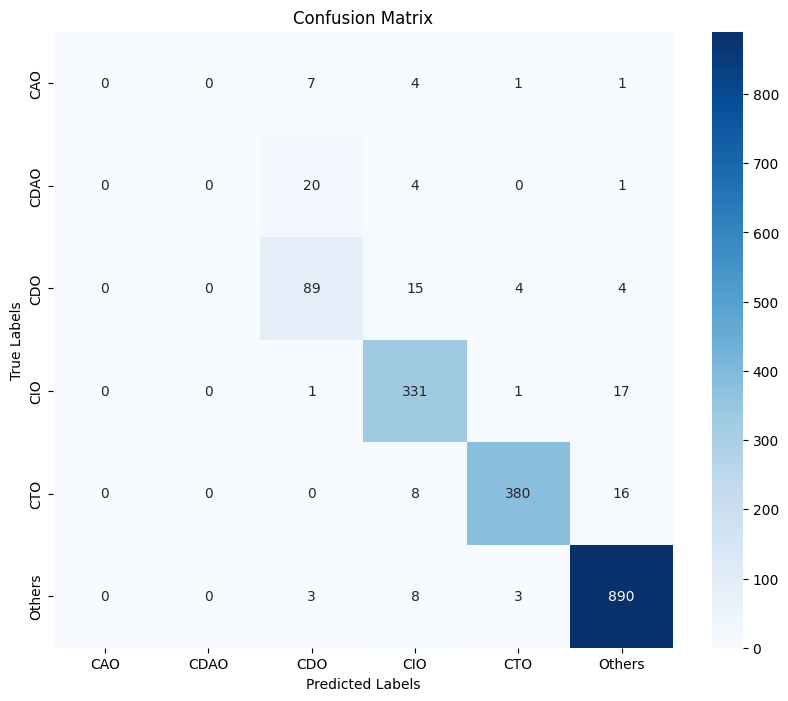

Ratio of CAO datapoints to total datapoints: 0.741314%


In [ ]:
from sklearn.metrics import confusion_matrix

# Total Recall
total_recall = report['macro avg']['recall']
print(f"\nTotal Recall: {total_recall}")

# Find class with least recall
min_recall = 1.0
min_recall_class = None
for class_label, metrics in report.items():
    if isinstance(metrics, dict) and 'recall' in metrics:
        if metrics['recall'] < min_recall:
            min_recall = metrics['recall']
            min_recall_class = class_label

if min_recall_class:
    print(f"\nClass with least recall: {min_recall_class} ({min_recall:.2f})")
    min_recall_class_name = label_encoder.inverse_transform([int(min_recall_class)])[0]
    print(f"\nClass Name with lowest recall: {min_recall_class_name} ({min_recall:.2f})")

    # Further analysis
    print("\nFurther Analysis for low recall:")
    print("1. Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    cio_datapoints = df[df['custom_cdo_cio_cto'] == min_recall_class_name].shape[0]
    total_datapoints = df.shape[0]
    cio_ratio = cio_datapoints / total_datapoints
    print(f"Ratio of {min_recall_class_name} datapoints to total datapoints: {cio_ratio*100:.6f}%")
else:
    print("\nCould not determine class with minimum recall.")


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
%cd /content/drive/My\ Drive/Internship/Model\ II

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Internship/Model II


In [ ]:
df = pd.read_csv('processed_data2.csv')

# Check class distribution
print(df['custom_cdo_cio_cto'].value_counts())

custom_cdo_cio_cto
Others    2029933
CTO          2018
CIO          1749
CDO           560
CDAO          125
CAO            67
Name: count, dtype: int64


In [ ]:
# Label encoding
label_encoder = LabelEncoder()
df['custom_cdo_cio_cto'] = label_encoder.fit_transform(df['custom_cdo_cio_cto'])

In [ ]:
# Extract features and labels
X = df['title'].astype(str).values
y = df['custom_cdo_cio_cto'].values

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# Apply SMOTE to balance minority classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_padded, y)

In [ ]:
# Stratified downsampling
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X_padded, y)

In [ ]:
# Convert y_resampled to DataFrame with a column named 'custom_cdo_cio_cto'
y_resampled_df = pd.DataFrame(y_resampled, columns=['custom_cdo_cio_cto'])

# Now you can use value_counts()
print(y_resampled_df['custom_cdo_cio_cto'].value_counts())

custom_cdo_cio_cto
0    67
1    67
2    67
3    67
4    67
5    67
Name: count, dtype: int64


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step - accuracy: 0.1571 - loss: 1.9338 - val_accuracy: 0.1481 - val_loss: 1.8893
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.1876 - loss: 1.8787 - val_accuracy: 0.1605 - val_loss: 1.8569
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.2053 - loss: 1.8418 - val_accuracy: 0.1235 - val_loss: 1.8742
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.2003 - loss: 1.8249 - val_accuracy: 0.1481 - val_loss: 1.8750
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.1313 - loss: 1.8261 - val_accuracy: 0.1358 - val_loss: 1.8558


In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1304 - loss: 1.8572
Test Accuracy: 0.1358
